In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [2]:
def parametrize(df):
    df_new = df.copy()
    for col in df_new.columns:
        if  col in ['Apr','Carrera','Campus','Sem','Depto','Sexo']:
            continue
        try:
                decimal =1
                cols= pd.to_numeric(df_new[col])
                df_new.loc[cols ==0,col]=0
                df_new.loc[ (cols<=45/decimal) & (cols>0), col]=1
                df_new.loc[ (cols>45/decimal) & (cols <= 55/decimal), col]=2
                df_new.loc[ (cols>55/decimal) & (cols <= 65/decimal), col]=3
                df_new.loc[ cols > 65/decimal, col]=4
        except:
                print(name,col)
    
    return df_new

In [3]:
def parametrize_col(col):
    x = col.copy()
    x[x==0] = 0
    x[x<=45] =1
    x[(x>45) & (x<=55)]=2
    x[(x>5) & (x<=65)]=3
    x[(x>6)]=4
    return x

In [8]:
df = pd.read_csv('../All_Rough_data.csv')
deptos = df.Depto
df.drop(columns=['SM9','SM10','Depto'],inplace=True)

In [9]:
_df=pd.get_dummies(data=parametrize(df),columns=['Campus','Sexo'])

In [10]:
pca = PCA(n_components=8)
pca_data = pca.fit_transform(_df)

In [16]:
_df.shape

(3706, 50)

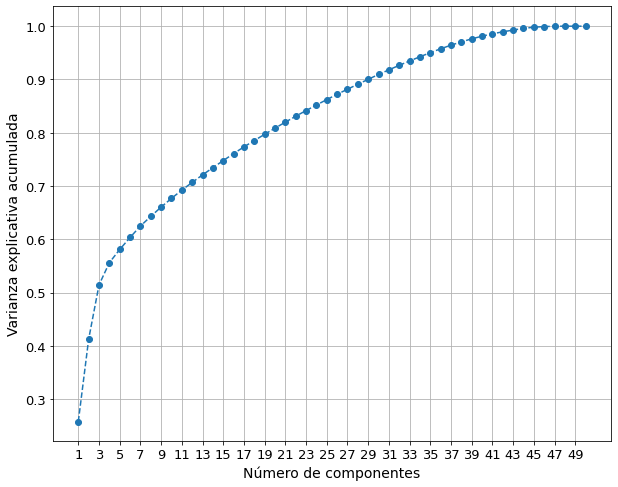

In [15]:

pca = PCA()
_df = pd.get_dummies(data=parametrize(df),columns=['Campus','Sexo'])
pca.fit(_df)
plt.figure(figsize=(10,8))
plt.plot(range(1,_df.shape[1]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('Número de componentes',fontdict={'fontsize':14})
plt.tick_params(labelsize=13)
plt.ylabel('Varianza explicativa acumulada',fontdict={'fontsize':14})
plt.xticks(ticks= np.arange(1,_df.shape[1]+1,2))
plt.grid()
plt.savefig('PCAVariance.png')

In [17]:
pca = PCA(n_components=19)
pca_data = pca.fit_transform(_df)

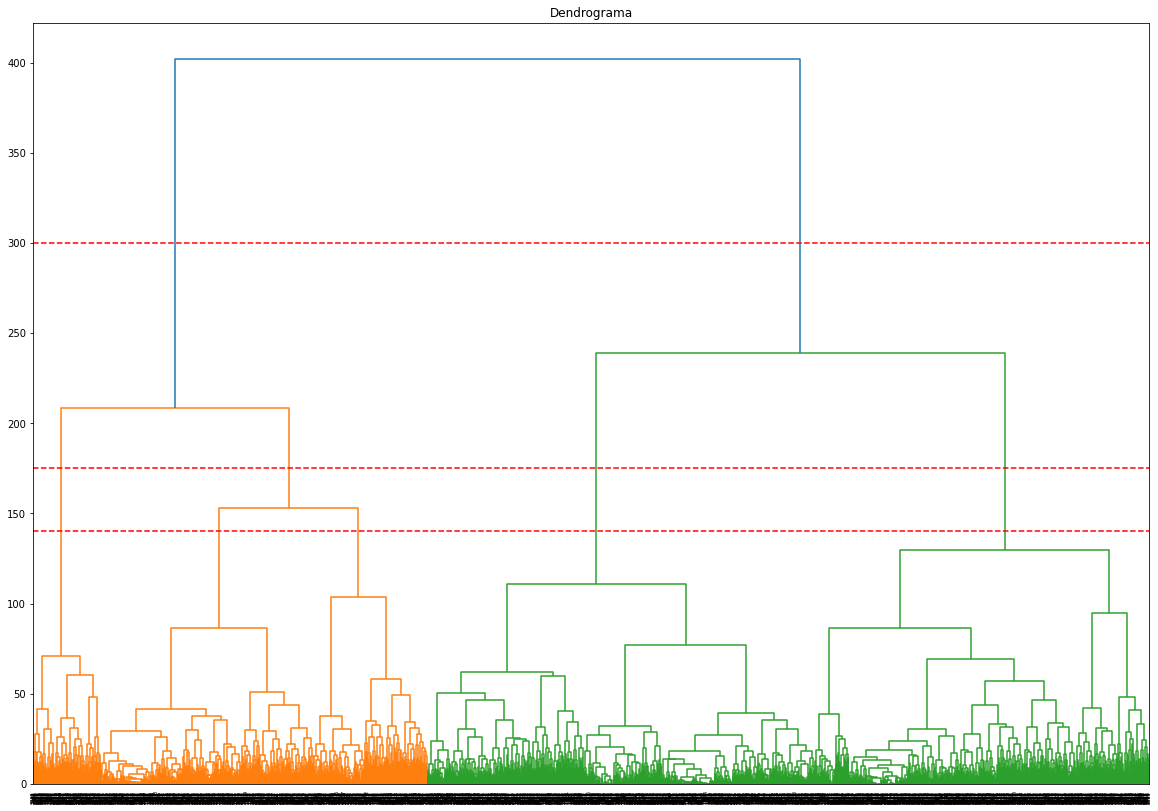

In [20]:
plt.figure(figsize=(20, 14))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(pca_data, method='ward'))
plt.axhline(y=140, color='r', linestyle='--',label='Corte 3')
plt.axhline(y=300, color = 'r', linestyle='--',label='Corte 1')
plt.axhline(y=175, color = 'r', linestyle='--',label='Corte 2')
#plt.show()
plt.savefig('DendogramaCluster.png')

In [111]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(pca_data)

In [114]:
cluster

AgglomerativeClustering(n_clusters=5)

In [38]:
from sklearn.metrics import silhouette_score
silhouette_score(pca_data,cluster.labels_)

0.1894840816535502

In [115]:
_df['labels']=cluster.labels_

In [116]:
_df

,C1,C2,CR,S1,S2,S3,S4,S5,S6,S7,...,NF,Carrera,Sem,Apr,Campus_0.0,Campus_1.0,Campus_2.0,Sexo_0,Sexo_1,labels
0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,...,4.0,11,2.0,1,1,0,0,1,0,0
1,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,4.0,5,2.0,1,1,0,0,1,0,2
2,4.0,4.0,0.0,4.0,0.0,0.0,4.0,2.0,0.0,4.0,...,4.0,10,2.0,1,1,0,0,1,0,1
3,0.0,4.0,0.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,...,2.0,7,1.0,0,1,0,0,1,0,2
4,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,6,2.0,1,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,1.0,1.0,0.0,4.0,0.0,4.0,4.0,4.0,1.0,3.0,...,1.0,15,2.0,0,0,0,1,0,1,3
3702,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,6,2.0,1,0,0,1,1,0,2
3703,4.0,3.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,6,2.0,1,0,0,1,1,0,2
3704,4.0,3.0,0.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,...,4.0,6,2.0,1,0,0,1,1,0,2


In [117]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

_df2=undummify(_df)

In [118]:
_df2

,C1,C2,CR,S1,S2,S3,S4,S5,S6,S7,...,SM6,SM7,SM8,NF,Carrera,Sem,Apr,Campus,Sexo,labels
0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,...,4.0,4.0,0.0,4.0,11,2.0,1,0.0,0,0
1,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,4.0,4.0,4.0,4.0,5,2.0,1,0.0,0,2
2,4.0,4.0,0.0,4.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0.0,4.0,4.0,4.0,10,2.0,1,0.0,0,1
3,0.0,4.0,0.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,...,4.0,4.0,4.0,2.0,7,1.0,0,0.0,0,2
4,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,6,2.0,1,0.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,1.0,1.0,0.0,4.0,0.0,4.0,4.0,4.0,1.0,3.0,...,0.0,0.0,0.0,1.0,15,2.0,0,2.0,1,3
3702,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,6,2.0,1,2.0,0,2
3703,4.0,3.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,6,2.0,1,2.0,0,2
3704,4.0,3.0,0.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,...,4.0,4.0,4.0,4.0,6,2.0,1,2.0,0,2


In [119]:
df['labels']=_df2['labels']
clusters= _df2.labels.sort_values().unique()

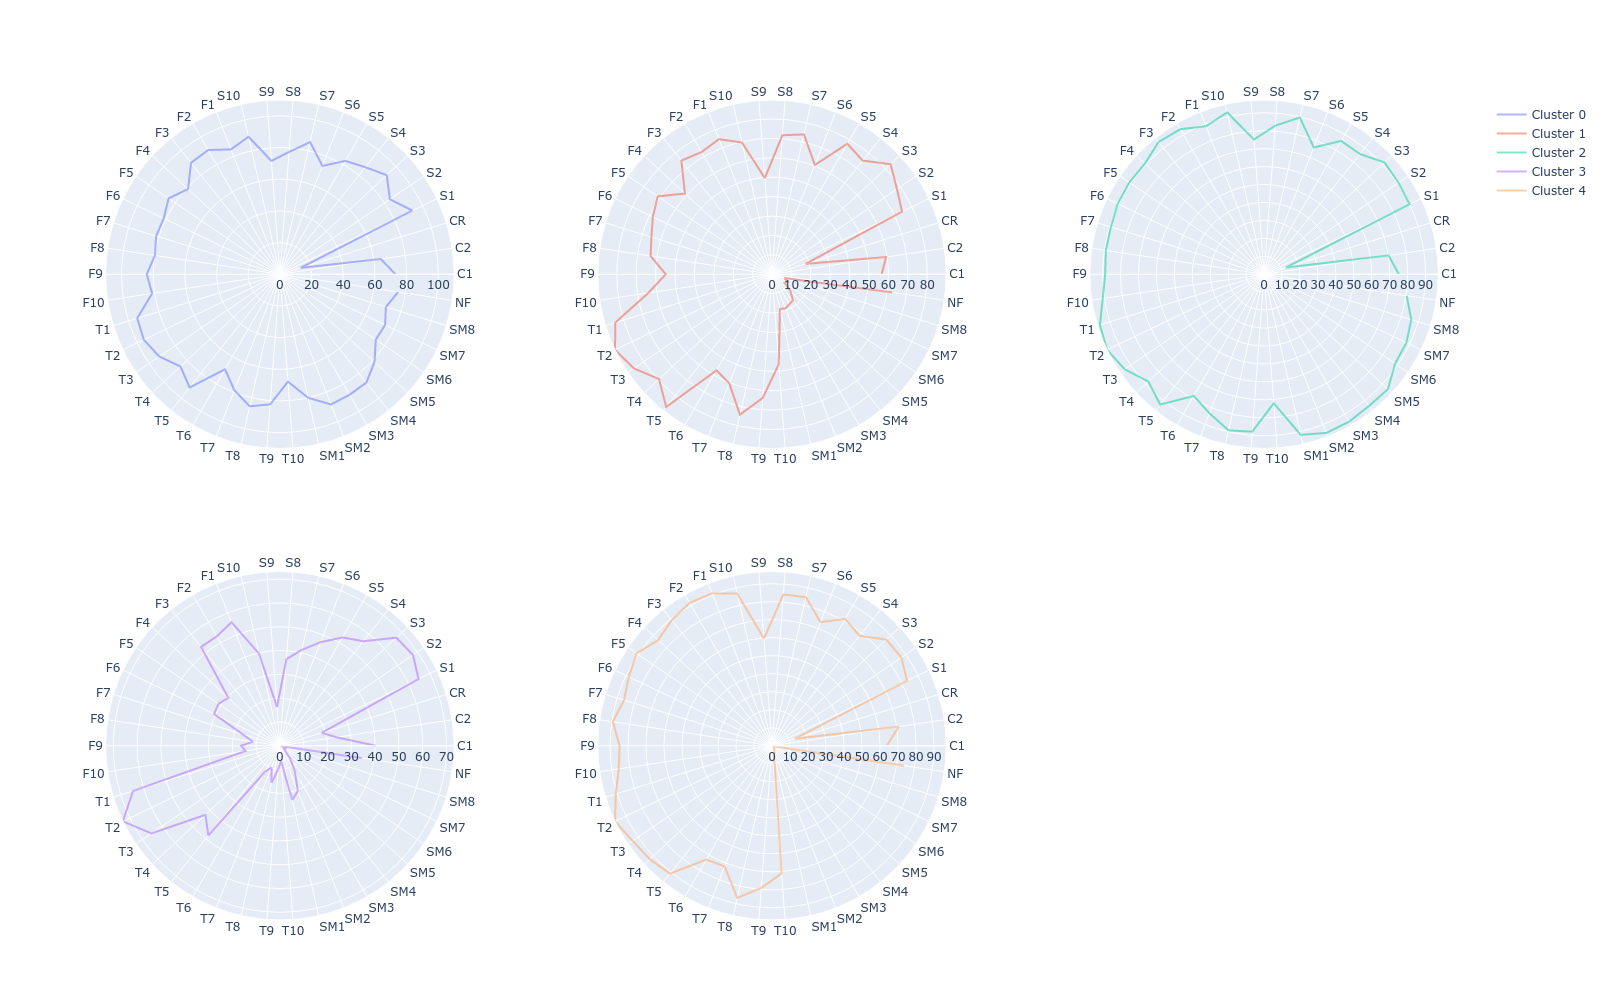

In [120]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


n = 3
m=2
db = df.drop(columns=['Carrera','Campus','Sem','Sexo','Apr'])
categories = df.drop(columns=['labels','Carrera','Campus','Sem','Sexo','Apr']).columns
fig = make_subplots(rows=m,cols=n,specs=[[{'type': 'polar'}]*n]*m)

for i in range(len(clusters)):
    radio= db[db.labels ==i].drop(columns=['labels']).mean().values
    fig.add_trace(go.Scatterpolar(
          r= [*radio, radio[0]],
          theta=categories,
          #fill='toself',
            opacity=0.5,
          name=f'Cluster {i}'
    ),
        row=(i//n) +1, 
        col= (i%n) +1,
                 )

fig.update_layout(
    autosize=False,
    width=1200,
       height=1000,
    showlegend=True,
    polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 110]
    )),
)

fig.show()
fig.write_image('ClusterH.png',format='png')

In [121]:
print(pd.concat(
    [
    pd.crosstab(_df2['labels'],_df2['Sexo'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Sem'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Campus'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Apr'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['NF'],normalize='index').T
    ]
    ,keys=['Sexo','Semestre','Campus', 'Aprobación','Nota']).to_latex()
)

\begin{tabular}{llrrrrr}
\toprule
     & labels &         0 &         1 &         2 &         3 &         4 \\
\midrule
Sexo & 0 &  0.688849 &  0.753968 &  0.743769 &  0.782222 &  0.807638 \\
     & 1 &  0.311151 &  0.246032 &  0.256231 &  0.217778 &  0.192362 \\
Semestre & 1.0 &  0.251799 &  0.735450 &  0.421340 &  0.582222 &  0.937765 \\
     & 2.0 &  0.748201 &  0.264550 &  0.578660 &  0.417778 &  0.062235 \\
Campus & 0.0 &  0.331835 &  0.531746 &  0.460280 &  0.453333 &  0.514851 \\
     & 1.0 &  0.598921 &  0.449735 &  0.442368 &  0.497778 &  0.478076 \\
     & 2.0 &  0.069245 &  0.018519 &  0.097352 &  0.048889 &  0.007072 \\
Aprobación & 0 &  0.123201 &  0.280423 &  0.082555 &  0.768889 &  0.151344 \\
     & 1.0 &  0.876799 &  0.719577 &  0.917445 &  0.231111 &  0.848656 \\
Nota & 1.0 &  0.096223 &  0.219577 &  0.054517 &  0.635556 &  0.114569 \\
     & 2.0 &  0.026978 &  0.060847 &  0.028037 &  0.133333 &  0.036775 \\
     & 3.0 &  0.048561 &  0.179894 &  0.027259 &  0.177778 &

In [77]:
aa.index.levels

FrozenList([[0, 1, 2, 3, 4], ['0', '1'], [1.0, 2.0], ['0.0', '1.0', '2.0'], [0, 1], [1.0, 2.0, 3.0, 4.0]])

In [94]:
aa = _df2.groupby(['labels','Sexo','Sem','Campus','Apr','NF']).C1.count().to_frame('cantidad').reset_index()

print(pd.crosstab(columns = aa.labels, index=[aa.Sem,aa.Campus,aa.Apr,aa.NF],values=aa.cantidad,normalize='columns',aggfunc=sum).to_latex())

\begin{tabular}{llllrrrrr}
\toprule
    &     &   & labels &         0 &         1 &         2 &         3 &         4 \\
Sem & Campus & Apr & NF &           &           &           &           &           \\
\midrule
1.0 & 0.0 & 0 & 1.0 &  0.012590 &  0.082011 &  0.013240 &  0.155556 &  0.049505 \\
    &     &   & 2.0 &  0.004496 &  0.026455 &  0.007009 &  0.053333 &  0.011315 \\
    &     & 1 & 3.0 &  0.006295 &  0.063492 &  0.002336 &  0.035556 &  0.031117 \\
    &     &   & 4.0 &  0.083633 &  0.283069 &  0.209502 &  0.017778 &  0.391796 \\
    & 1.0 & 0 & 1.0 &  0.017986 &  0.074074 &  0.007009 &  0.168889 &  0.043847 \\
    &     &   & 2.0 &  0.005396 &  0.013228 &  0.003115 &  0.017778 &  0.018388 \\
    &     & 1 & 3.0 &  0.007194 &  0.037037 &  0.006231 &  0.071111 &  0.028289 \\
    &     &   & 4.0 &  0.068345 &  0.150794 &  0.169003 &  0.026667 &  0.362093 \\
    & 2.0 & 0 & 1.0 &  0.008993 &  0.002646 &  0.000779 &  0.031111 &  0.001414 \\
    &     &   & 2.0 &  0.001799 &  

In [97]:
_df2['Promedio Tareas'] = parametrize_col(df.filter(regex='T').mean(axis=1))
_df2['Promedio Formativos'] = parametrize_col(df.filter(regex='F').mean(axis=1))
_df2['Promedio Actividades'] = parametrize_col(df.filter(regex='SM').mean(axis=1))
_df2['Promedio Tareas'] = parametrize_col(df.filter(regex='T').mean(axis=1))
_df2['Promedio Controles'] = parametrize_col(df.filter(regex='S[0-9]').mean(axis=1))

In [98]:
print(pd.concat(
    [
    pd.crosstab(_df2['labels'],_df2['C1'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['C2'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio_Controles'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio_Tareas'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio_Formativos'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio_Actividades'],normalize='index').T
    ]
    ,keys=['C1','C2','Controles', 'Tareas','Formativos','Actividades']).to_latex()
)

\begin{tabular}{llrrrrr}
\toprule
            & labels &         0 &         1 &         2 &         3 &         4 \\
\midrule
C1 & 0.0 &  0.026978 &  0.031746 &  0.010903 &  0.075556 &  0.018388 \\
            & 1.0 &  0.133993 &  0.365079 &  0.141745 &  0.533333 &  0.265912 \\
            & 2.0 &  0.080935 &  0.108466 &  0.077882 &  0.124444 &  0.138614 \\
            & 3.0 &  0.082734 &  0.097884 &  0.072430 &  0.048889 &  0.104668 \\
            & 4.0 &  0.675360 &  0.396825 &  0.697040 &  0.217778 &  0.472419 \\
C2 & 0.0 &  0.125000 &  0.156085 &  0.105140 &  0.528889 &  0.108911 \\
            & 1.0 &  0.142986 &  0.161376 &  0.111371 &  0.235556 &  0.087694 \\
            & 2.0 &  0.071942 &  0.089947 &  0.060748 &  0.048889 &  0.042433 \\
            & 3.0 &  0.105216 &  0.092593 &  0.082555 &  0.031111 &  0.094767 \\
            & 4.0 &  0.554856 &  0.500000 &  0.640187 &  0.155556 &  0.666195 \\
Controles & 1.0 &  0.015288 &  0.089947 &  0.001558 &  0.448889 &  0.022631 \\
  

In [110]:
aa = _df2.groupby(['labels','C1','C2','Apr','Promedio Controles','Promedio Tareas','Promedio Formativos','Promedio Actividades']).C1.count().to_frame('cantidad').reset_index()
pd.crosstab(columns=aa.labels , index=[aa.C1,aa.C2,aa.Apr], values = aa.cantidad,aggfunc=sum,normalize='columns').apply(lambda x: x.nlargest(10))

labels              0         1         2         3         4
C1  C2  Apr                                                  
0.0 1.0 0         NaN       NaN       NaN  0.044444       NaN
    4.0 0         NaN       NaN       NaN  0.022222       NaN
1.0 0.0 0    0.027878  0.079365  0.017913  0.320000  0.036775
    1.0 0         NaN  0.068783       NaN  0.115556  0.031117
    2.0 1         NaN  0.034392       NaN       NaN       NaN
    3.0 1         NaN       NaN       NaN       NaN  0.018388
    4.0 1    0.054856  0.111111  0.073988  0.035556  0.140028
2.0 0.0 0         NaN       NaN       NaN  0.075556  0.022631
    4.0 1    0.032374  0.047619  0.041277  0.026667  0.084866
3.0 1.0 0         NaN       NaN       NaN  0.022222       NaN
        1    0.024281       NaN       NaN       NaN       NaN
    4.0 1    0.034173  0.050265  0.044393       NaN  0.076379
4.0 0.0 0         NaN  0.023810  0.018692  0.093333  0.021216
        1    0.037770       NaN  0.049065       NaN       NaN
    1.0 1    0.073741  0.031746  0.068536       NaN       NaN
    2.0 1    0.048561       NaN  0.038162       NaN       NaN
    3.0 1    0.071043  0.042328  0.052181       NaN  0.045262
    4.0 1    0.416367  0.264550  0.470405  0.048889  0.360679

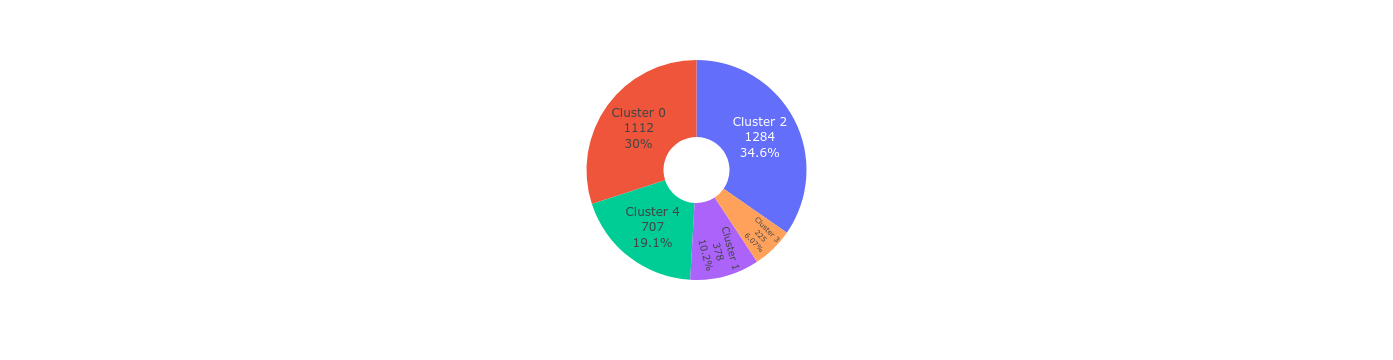

In [185]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
df_pie=df.labels.sort_values().value_counts(sort=False).to_frame().reset_index()
df_pie['index']= [f'Cluster {i}' for i in range(len(df_pie))]
fig = px.pie(df_pie, values='labels', names='index',hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label+value',showlegend=False)
fig.show()
fig.write_image('JeraarquicoPie.png',format='png')

In [195]:
df.to_csv('df_jerarquico.csv',index=False)

In [191]:
from utils import *

In [175]:
pca, score_pca = fit_pca(pd.get_dummies(data=parametrize(df.drop(columns=['labels'])),columns=['Campus','Sexo']))

In [176]:
df_val = pd.read_csv('../2021-02.csv',dtype={'Campus':float,'Sem':float}).iloc[:,1:]
df_val.drop(columns=['Depto'],inplace=True)

In [177]:
_df_val=pd.get_dummies(data=parametrize(df_val),columns=['Campus','Sexo'])
_df_val.fillna(0,inplace=True)

In [178]:
pca_data2 = pca.transform(_df_val)

In [179]:
from sklearn import metrics
print( f'Davies Bouldin Score: {metrics.davies_bouldin_score(pca_data,df.labels)}')
print(f'Silhoutte Score: {metrics.silhouette_score(pca_data,df.labels)}')
print(f'Calinski harabasz Score: {metrics.calinski_harabasz_score(pca_data,df.labels)}')
metrics.silhouette_samples(pca_data,df.labels).mean()

Davies Bouldin Score: 1.8854941233647513
Silhoutte Score: 0.1894840816535502
Calinski harabasz Score: 717.1795744992969


0.1894840816535502

In [186]:
predicted_labels=get_predicted_labels(pca_data2,pca_data,df.labels)

In [193]:
plot_piechart()

NameError: name 'plot_piechart' is not defined